# Improvement Notebook Objective: Application Analysis of FCPO Model in E-Commerce Domain

Analyzing how well the framework from the paper adapts to different recommendation systems is crucial, given its focus on movie recommendations. 

In **e-commerce**, where product diversity and seller visibility are key concerns, the method’s dynamic fairness approach would need to address the challenge of balancing fairness across rapidly changing inventory and seller performaments.

---

### Dataset Overview: E-Commerce Purchase Dataset
We utilize the [E-Commerce Purchase Dataset](https://www.kaggle.com/datasets/raosuny/e-commerce-purchase-dataset) from Kaggle. This dataset contains detailed purchase records, providing valuable insights into customer behavior, product categories, and transaction details. It serves as an ideal base for testing the dynamic fairness approach in a real-world e-commerce context.

Key Features of the Dataset:
- **Customer_ID**: Unique identifier for each customer (mapped to `user_id`).
- **Product_Category**: The category of the purchased product (mapped to `item_id`).
- **Purchase Details**: Includes transaction details such as amount spent, date of transaction, payment method, etc.

Thias it has transaction which is s dataset is  dynamicsed to simulate an e-commerce environment for evaluating the FCPO model.

---

### Mapping of Variables:
1. **customer_id** corresponds to **user_id**.
2. **product_category** corresponds to **item_id**.
3. **rating** is derived from `clicks_in_site / time_on_site`, where both are non-null.

---

### Implicit Ratings:
- Implicit ratings are used, as explicit feedback may not always be available.
- Ratings are calculated based on user behavior:
  - **Clicks per unit time** (`clicks_in_site / time_on_site`) is utilized as a proxy for interest.
  - **Observation**: Spending more time on the site tends to lead to a steady increase in clicks, making click rate a reliable gauge of user interest.
ge of user interest.


In [1]:
from argparse import ArgumentParser
import pandas as pd
import numpy as np

import os
import random
import csv
import time
from datetime import datetime as dt, timedelta
import ast  

import itertools
from itertools import chain, starmap
from functools import wraps
from inspect import getfullargspec, isfunction
from collections import defaultdict, namedtuple

import matplotlib.pyplot as plt
import matplotlib


import torch
from torch.autograd import grad
import torch.nn.functional as F
from torch.nn import Linear, LogSoftmax, Module, Parameter, Sequential, Tanh, GRU, MSELoss
from torch.optim import LBFGS
from torch.distributions import Independent
from torch.distributions.categorical import Categorical
from torch.distributions.normal import Normal
from torch.distributions.kl import kl_divergence

## Markdowns

In [2]:
class MultinomialLayer(Module):
    '''
    Implements a layer that outputs a multinomial distribution

    Methods
    ------
    __call__(log_action_probs)
        Takes as input log probabilities and outputs a pytorch multinomail
        distribution
    '''

    def __init__(self):
        Module.__init__(self)

    def __call__(self, log_action_probs):
        return Categorical(logits=log_action_probs)


class DiagGaussianLayer(Module):
    '''
    Implements a layer that outputs a Gaussian distribution with a diagonal
    covariance matrix

    Attributes
    ----------
    log_std : torch.FloatTensor
        the log square root of the diagonal elements of the covariance matrix

    Methods
    -------
    __call__(mean)
        takes as input a mean vector and outputs a Gaussian distribution with
        diagonal covariance matrix defined by log_std

    '''

    def __init__(self, output_dim=None, log_std=None):
        Module.__init__(self)

        self.log_std = log_std

        if log_std is None:
            self.log_std = Parameter(torch.zeros(output_dim), requires_grad=True)

    def __call__(self, mean):
        std = torch.exp(self.log_std)
        normal_dist = Independent(Normal(loc=mean, scale=std), 1)

        return normal_dist


def build_layers(input_dim, hidden_dims, output_dim):
    '''
    Returns a list of Linear and Tanh layers with the specified layer sizes

    Parameters
    ----------
    input_dim : int
        the input dimension of the first linear layer

    hidden_dims : list
        a list of type int specifying the sizes of the hidden layers

    output_dim : int
        the output dimension of the final layer in the list

    Returns
    -------
    layers : list
        a list of Linear layers, each one followed by a Tanh layer, excluding the
        final layer
    '''

    layer_sizes = [input_dim] + hidden_dims + [output_dim]
    layers = []

    for i in range(len(layer_sizes) - 1):
        layers.append(Linear(layer_sizes[i], layer_sizes[i + 1], bias=True))

        if i != len(layer_sizes) - 2:
            layers.append(Tanh())

    return layers

def build_mlp(input_dim, hidden_dims, output_dim):
    '''
    Build a multilayer perceptron with tanh activations with the specified input,
    output, and hidden layer sizes

    Parameters
    ----------
    input_dim : int
        the input dimension of the first linear layer

    hidden_dims : list
        a list of type int specifying the sizes of the hidden layers

    output_dim : int
        the output dimension of the final layer in the list

    Returns
    -------
    mlp : torch.nn.Sequential
        a pytorch sequential model that defines a MLP
    '''

    mlp = Sequential(*build_layers(input_dim, hidden_dims, output_dim))

    return mlp

def build_diag_gauss_policy(state_dim, hidden_dims, action_dim,
    log_std=None):
    '''
    Build a multilayer perceptron with a DiagGaussianLayer at the output layer

    Parameters
    ----------
    state_dim : int
        the input size of the network

    hidden_dims : list
        a list of type int specifying the sizes of the hidden layers

    action_dim : int
        the dimensionality of the Gaussian distribution to be outputted by the
        policy

    log_std : torch.FloatTensor
        the log square root of the diagonal elements of the covariance matrix
        (will be set to a vector of zeros if none is specified)

    Returns
    -------
    policy : torch.nn.Sequential
        a pytorch sequential model that outputs a Gaussian distribution
    '''

    layers = build_layers(state_dim, hidden_dims, action_dim)
    layers[-1].weight.data *= 0.1
    layers[-1].bias.data *= 0.0
    layers.append(DiagGaussianLayer(action_dim, log_std))
    policy = Sequential(*layers)

    return policy


class Actor(Module):
    def __init__(self, input_size, hidden_size, state_dim, hidden_dims, action_dim):
        super(Actor, self).__init__()
        self.gru = GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.policy = build_diag_gauss_policy(state_dim, hidden_dims, action_dim)

    def forward(self, x):
        x = x.transpose(1,2)
        gru_output, _ = self.gru(x)
        batch_size = gru_output.size(0)
        output = self.policy(gru_output.view(batch_size, -1))
        return output


class Critic(Module):
    def __init__(self, input_size, hidden_size, input_dim, hidden_dims, output_dim):
        super(Critic, self).__init__()
        self.gru = GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.mlp = build_mlp(input_dim, hidden_dims, output_dim)
    
    def forward(self, x, y):
        x = x.transpose(1,2)
        gru_output, _ = self.gru(x)
        batch_size = gru_output.size(0)
        z = torch.cat([gru_output.view(batch_size,-1),y],dim=1)
        output = self.mlp(z)
        return output

## Memory

In [3]:
class Trajectory:
    def __init__(self):
        self.observations = []
        self.actions = []
        self.rewards = []
        self.costs = []
        self.done = False

    def __len__(self):
        return len(self.observations)


class Memory:
    def __init__(self, trajectories):
        self.trajectories = trajectories

    def sample(self):
        observations = torch.cat([torch.stack(trajectory.observations) for trajectory in self.trajectories])
        actions = torch.cat([torch.stack(trajectory.actions) for trajectory in self.trajectories])
        rewards = torch.cat([torch.tensor(trajectory.rewards) for trajectory in self.trajectories])
        costs = torch.cat([torch.tensor(trajectory.costs) for trajectory in self.trajectories])

        return observations, actions, rewards, costs

    def __getitem__(self, i):
        return self.trajectories[i]

## Fair Env Environment

In [4]:
class Environment ():
	def __init__(self, data, nb_user, nb_item, item_embeddings, user_embeddings, item_indicator, gamma, device, frac):
		self.data = data
		self.data_length = len(data)
		self.nb_user = nb_user
		self.nb_item = nb_item
		self.item_embeddings = item_embeddings
		self.user_embeddings = user_embeddings
		self.item_indicator = torch.from_numpy(item_indicator).float().to(device)
		self.gamma = gamma
		self.device = device
		self.frac = frac
		self.current_state = self.reset()

	def reset(self):
		current_data = self.data.sample(frac=self.frac)
		self.current_user = current_data['user'].to_list()
		self.nb_user = len(self.current_user)
		self.current_state = self.item_embeddings[current_data['state'].to_list()] 
		user_history = []
		for u_h in current_data['history'].values:
			h = torch.LongTensor(u_h)
			h_onehot = torch.FloatTensor(self.nb_item).zero_()
			h_onehot.scatter_(0, h, 1)
			user_history.append(h_onehot)
		self.current_user_history = torch.stack(user_history).to(self.device)
		return self.current_state

	def step(self, actions, item_idxes):
		costs = torch.sum(self.item_indicator[item_idxes],1)
		total_rewards = torch.zeros(self.nb_user).to(self.device)
		info = []
		
		for i in range(item_idxes.shape[1]):
			item_idxes_onehot = torch.FloatTensor(self.nb_user,self.nb_item).zero_().to(self.device)
			item_idxes_onehot.scatter_(1, item_idxes[:,i].view(-1,1), 1)

			results_onehot = torch.mul(self.current_user_history, item_idxes_onehot)
			info.append(torch.sum(results_onehot, 1))
			total_rewards += (self.gamma**i) * torch.sum(results_onehot, 1)

			mask =  torch.FloatTensor([0.5]*self.nb_user).view(-1,1).to(self.device)    
			masked_res = torch.cat((results_onehot, mask),dim=1)
			results = torch.argmax(masked_res,1)

			for j in range(len(results)):
				k = results[j]
				if k != self.nb_item:
					temp = np.append (self.current_state[j], [self.item_embeddings[k]], axis = 0)
					self.current_state[j] = np.delete (temp, 0, axis = 0)
					
			self.current_user_history = torch.mul(self.current_user_history, 1 - item_idxes_onehot)
			
		res = torch.stack(info).view(-1,item_idxes.shape[1])
		return self.current_state, total_rewards, costs, res

## Data Utils

In [5]:
def read_file(filename):
    df = pd.read_csv(filename)
    state = [ast.literal_eval(i) for i in df['state'].values.tolist()]
    user = df['user'].values.tolist()
    history = [np.array(ast.literal_eval(i)) for i in df['history'].values.tolist()]
    
    data = pd.DataFrame ()
    data['user'] = user
    data['state'] = state
    data['history'] = history
    return data

## Gini

In [6]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

## Autoassign file

In [7]:
def autoassign(*names, **kwargs):
    if kwargs:
        exclude, f = set(kwargs['exclude']), None
        sieve = lambda l:filter(lambda nv: nv[0] not in exclude, l)
    elif len(names) == 1 and isfunction(names[0]):
        f = names[0]
        sieve = lambda l:l
    else:
        names, f = set(names), None
        sieve = lambda l: filter(lambda nv: nv[0] in names, l)
    def decorator(f):
        fargnames, _, _, fdefaults, _, _, _ = getfullargspec(f)
        # Remove self from fargnames and make sure fdefault is a tuple
        fargnames, fdefaults = fargnames[1:], fdefaults or ()
        defaults = list(sieve(zip(reversed(fargnames), reversed(fdefaults))))
        @wraps(f)
        def decorated(self, *args, **kwargs):
            assigned = dict(sieve(zip(fargnames, args)))
            assigned.update(sieve(kwargs.items()))
            for _ in starmap(assigned.setdefault, defaults): pass
            self.__dict__.update(assigned)
            return f(self, *args, **kwargs)
        return decorated
    return f and decorator(f) or decorator

## torch_utils folder

In [8]:
def flatten(vecs):
    flattened = torch.cat([v.view(-1) for v in vecs])

    return flattened

def flat_grad(functional_output, inputs, retain_graph=False, create_graph=False):
    if create_graph == True:
        retain_graph = True

    grads = grad(functional_output, inputs, retain_graph=retain_graph, create_graph=create_graph)
    flat_grads = flatten(grads)

    return flat_grads

In [9]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def set_params(parameterized_fun, new_params):    
    n = 0

    for param in parameterized_fun.parameters():
        numel = param.numel()
        new_param = new_params[n:n + numel].view(param.size())
        param.data = new_param
        n += numel
        
def get_flat_params(parameterized_fun):
    parameters = parameterized_fun.parameters()
    flat_params = flatten([param.view(-1) for param in parameters])

    return flat_params

def normalize(x):
    mean = torch.mean(x)
    std = torch.std(x)
    x_norm = (x - mean) / std

    return x_norm

In [10]:
def mean_kl_first_fixed(dist_1, dist_2):
    if type(dist_1) is Categorical:
        dist_1_detached  = Categorical(logits=dist_1.logits.detach())
    elif type(dist_1) is Independent:
        dist_1_detached  = Normal(loc=dist_1.mean.detach(), scale=dist_1.stddev.detach())
        dist_1_detached  = Independent(dist_1_detached, 1)
        
        
    mean_kl = torch.mean(kl_divergence(dist_1_detached, dist_2))

    return mean_kl

## Optimization utils folder


### conjugate_gradient

In [11]:
def cg_solver(Avp_fun, b, device, max_iter=10):
    device = device
    x = torch.zeros_like(b).to(device)
    r = b.clone()
    p = b.clone()

    for i in range(max_iter):
        Avp = Avp_fun(p, retain_graph=True)

        alpha = torch.matmul(r, r) / torch.matmul(p, Avp)
        x += alpha * p

        if i == max_iter - 1:
            return x

        r_new = r - alpha * Avp
        beta = torch.matmul(r_new, r_new) / torch.matmul(r, r)
        r = r_new
        p = r + beta * p

### hvp

In [12]:
def get_Hvp_fun(functional_output, inputs, damping_coef=0.0):
    inputs = list(inputs)
    grad_f = flat_grad(functional_output, inputs, create_graph=True)
    def Hvp_fun(v, retain_graph=True):
        gvp = torch.matmul(grad_f, v)
        Hvp = flat_grad(gvp, inputs, retain_graph=retain_graph)
        Hvp += damping_coef * v

        return Hvp

    return Hvp_fun

### line_search

In [13]:
def line_search(search_dir, max_step_len, constraints_satisfied, line_search_coef=0.9,
                max_iter=10):
    step_len = max_step_len / line_search_coef

    for i in range(max_iter):
        step_len *= line_search_coef

        if constraints_satisfied(step_len * search_dir, step_len):
            return step_len

    return torch.tensor(0.0)

## CPO file

In [14]:
save_dir = '/kaggle/working/'

def discount(vals, discount_term):
    n = vals.size(0)
    disc_pows = torch.pow(discount_term, torch.arange(n).float())
    reverse_indxs = torch.arange(n - 1, -1, -1)

    discounted = torch.cumsum((vals * disc_pows)[reverse_indxs], dim=-1)[reverse_indxs] / disc_pows

    return discounted

def compute_advs(actual_vals, exp_vals, discount_term, bias_red_param):
    exp_vals_next = torch.cat([exp_vals[1:], torch.tensor([0.0])])
    td_res = actual_vals + discount_term * exp_vals_next - exp_vals
    advs = discount(td_res, discount_term * bias_red_param)

    return advs


class CPO:
    @autoassign
    def __init__(self, policy, value_fun, cost_fun, simulator, device, max_kl=1e-2, max_val_step=1e-2,
                 max_cost_step=1e-2, max_constraint_val=0.1, val_iters=1, cost_iters=1, val_l2_reg=1e-3,
                 cost_l2_reg=1e-3, discount_val=0.995, discount_cost=0.995, bias_red_val=0.98,
                 bias_red_cost=0.98, cg_damping=1e-3, cg_max_iters=10, line_search_coef=0.9,
                 line_search_max_iter=10, line_search_accept_ratio=0.1, model_name=None,
                 continue_from_file=False, save_every=5, print_updates=True):
        self.mse_loss = MSELoss(reduction='mean')
        self.value_optimizer = LBFGS(self.value_fun.parameters(), lr=max_val_step, max_iter=25)
        self.cost_optimizer = LBFGS(self.cost_fun.parameters(), lr=max_cost_step, max_iter=25)
        self.episode_num = 0
        self.elapsed_time = timedelta(0)
        self.device = device
        self.mean_rewards = []
        self.mean_costs = []

        if not model_name and continue_from_file:
            raise Exception('Argument continue_from_file to __init__ method of ' \
                            'CPO case was set to True but model_name was not ' \
                            'specified.')

        if not model_name and save_every:
            raise Exception('Argument save_every to __init__ method of CPO ' \
                            'was set to a value greater than 0 but model_name ' \
                            'was not specified.')

        if continue_from_file:
            self.load_session()

    def train(self, n_episodes):
        states_w_time_prev = None
        disc_rewards_prev = None
        disc_costs_prev = None

        while self.episode_num < n_episodes:
            start_time = dt.now()
            self.episode_num += 1

            memory = self.simulator.run_sim()
            observations, actions, rewards, costs = memory.sample()

            trajectory_sizes = torch.tensor([len(trajectory) for trajectory in memory])
            trajectory_limits = torch.cat([torch.tensor([0]), torch.cumsum(trajectory_sizes, dim=-1)])
            N = np.sum([len(trajectory) for trajectory in memory])
            T = self.simulator.trajectory_len
            time = torch.cat([torch.arange(size).float() for size in trajectory_sizes])
            time = torch.unsqueeze(time, dim=1) / T
            
#             print(observations.shape,time.shape)
            states_w_time = torch.cat([observations.to(self.device), time.to(self.device)], dim=1)

            disc_rewards = torch.zeros(N)
            disc_costs = torch.zeros(N)
            reward_advs = torch.zeros(N)
            cost_advs = torch.zeros(N)

            with torch.no_grad():
                state_vals = self.value_fun(states_w_time.to(self.device)).view(-1).cpu()
                state_costs = self.cost_fun(states_w_time.to(self.device)).view(-1).cpu()
           
            for start, end in zip(trajectory_limits[:-1], trajectory_limits[1:]):
                disc_rewards[start:end] = discount(rewards[start:end], self.discount_val)
                disc_costs[start:end] = discount(costs[start:end], self.discount_cost)
                reward_advs[start:end] = compute_advs(rewards[start:end],
                                                      state_vals[start:end],
                                                      self.discount_val,
                                                      self.bias_red_val)
                cost_advs[start:end] = compute_advs(costs[start:end],
                                                    state_costs[start:end],
                                                    self.discount_cost,
                                                    self.bias_red_cost)

            reward_advs -= reward_advs.mean()
            reward_advs /= reward_advs.std()
#             cost_advs -= reward_advs.mean()
            cost_advs -= cost_advs.mean()
            cost_advs /= cost_advs.std()

            if states_w_time_prev is not None:
                states_w_time_train = torch.cat([states_w_time, states_w_time_prev])
                disc_rewards_train = torch.cat([disc_rewards, disc_rewards_prev])
                disc_costs_train = torch.cat([disc_costs, disc_costs_prev])
            else:
                states_w_time_train = states_w_time
                disc_rewards_train = disc_rewards
                disc_costs_train = disc_costs

            states_w_time_prev = states_w_time
            disc_rewards_prev = disc_rewards
            disc_costs_prev = disc_costs

#             constraint_cost = torch.mean(torch.tensor([disc_costs[start] for start in trajectory_limits[:-1]]))
            constraint_cost = torch.mean(torch.tensor([torch.sum(torch.tensor(trajectory.costs))
                                                       for trajectory in memory]))

            self.update_policy(observations, actions, reward_advs, cost_advs, constraint_cost)
            self.update_nn_regressor(self.value_fun, self.value_optimizer, states_w_time_train,
                                     disc_rewards_train, self.val_l2_reg, self.val_iters)
            self.update_nn_regressor(self.cost_fun, self.cost_optimizer, states_w_time_train,
                                     disc_costs_train, self.cost_l2_reg, self.cost_iters)

            reward_sums = [np.sum(trajectory.rewards) for trajectory in memory]
#             print(reward_sums)
            cost_sums = [np.sum(trajectory.costs) for trajectory in memory]
            self.mean_rewards.append(torch.mean(torch.Tensor(reward_sums)))
            self.mean_costs.append(torch.mean(torch.Tensor(cost_sums)))
            self.elapsed_time += dt.now() - start_time

            if self.print_updates:
                self.print_update()

            if self.save_every and not self.episode_num % self.save_every:
                self.save_session()

    def update_policy(self, observations, actions, reward_advs, constraint_advs, J_c):
        self.policy.train()

        observations = observations.to(self.device)
        actions = actions.to(self.device)
        reward_advs = reward_advs.to(self.device)
        constraint_advs = constraint_advs.to(self.device)

        action_dists = self.policy(observations)
        log_action_probs = action_dists.log_prob(actions)
#         print(action_dists.shape)
#         print(log_action_probs.shape)

        imp_sampling = torch.exp(log_action_probs - log_action_probs.detach())
        # Change to torch.matmul
        reward_loss = -torch.mean(imp_sampling * reward_advs)
        reward_grad = flat_grad(reward_loss, self.policy.parameters(), retain_graph=True)
        # Change to torch.matmul
        constraint_loss = torch.sum(imp_sampling * constraint_advs) / self.simulator.n_trajectories
        constraint_grad = flat_grad(constraint_loss, self.policy.parameters(), retain_graph=True)

        mean_kl = mean_kl_first_fixed(action_dists, action_dists)
        Fvp_fun = get_Hvp_fun(mean_kl, self.policy.parameters())

        F_inv_g = cg_solver(Fvp_fun, reward_grad, self.device)
        F_inv_b = cg_solver(Fvp_fun, constraint_grad, self.device)

        q = torch.matmul(reward_grad, F_inv_g)
        r = torch.matmul(reward_grad, F_inv_b)
        s = torch.matmul(constraint_grad, F_inv_b)
        c = (J_c - self.max_constraint_val).to(self.device)

        is_feasible = False if c > 0 and c ** 2 / s - 2 * self.max_kl > 0 else True

        if is_feasible:
            lam, nu = self.calc_dual_vars(q, r, s, c)
            search_dir = -lam ** -1 * (F_inv_g + nu * F_inv_b)
        else:
            search_dir = -torch.sqrt(2 * self.max_kl / s) * F_inv_b

        # Should be positive
        exp_loss_improv = torch.matmul(reward_grad, search_dir)
        current_policy = get_flat_params(self.policy)

        def line_search_criterion(search_dir, step_len):
            test_policy = current_policy + step_len * search_dir
            set_params(self.policy, test_policy)

            with torch.no_grad():
                # Test if conditions are satisfied
                test_dists = self.policy(observations)
                test_probs = test_dists.log_prob(actions)

                imp_sampling = torch.exp(test_probs - log_action_probs.detach())

                test_loss = -torch.mean(imp_sampling * reward_advs)
                test_cost = torch.sum(imp_sampling * constraint_advs) / self.simulator.n_trajectories
                test_kl = mean_kl_first_fixed(action_dists, test_dists)

                loss_improv_cond = (test_loss - reward_loss) / (step_len * exp_loss_improv) >= self.line_search_accept_ratio
                cost_cond = step_len * torch.matmul(constraint_grad, search_dir) <= max(-c, 0.0)
                kl_cond = test_kl <= self.max_kl

            set_params(self.policy, current_policy)

            if is_feasible:
                return loss_improv_cond and cost_cond and kl_cond

            return cost_cond and kl_cond

        step_len = line_search(search_dir, 1.0, line_search_criterion, self.line_search_coef)
        print('Step Len.:', step_len)
        new_policy = current_policy + step_len * search_dir
        set_params(self.policy, new_policy)

    def update_nn_regressor(self, nn_regressor, optimizer, states, targets, l2_reg_coef, n_iters=1):
        nn_regressor.train()

        states = states.to(self.device)
        targets = targets.to(self.device)

        for _ in range(n_iters):
            def mse():
                optimizer.zero_grad()

                predictions = nn_regressor(states).view(-1)
                loss = self.mse_loss(predictions, targets)

                flat_params = get_flat_params(nn_regressor)
                l2_loss = l2_reg_coef * torch.sum(torch.pow(flat_params, 2))
                loss += l2_loss

                loss.backward()

                return loss

            optimizer.step(mse)

    def calc_dual_vars(self, q, r, s, c):
        if c < 0.0 and c ** 2 / s - 2 * self.max_kl > 0.0:
            lam = torch.sqrt(q / (2 * self.max_kl))
            nu = 0.0

            return lam, nu

        A = q - r ** 2 / s
        B = 2 * self.max_kl - c ** 2 / s

        lam_mid = r / c
        lam_a = torch.sqrt(A / B)
        lam_b = torch.sqrt(q / (2 * self.max_kl))

        f_mid = -0.5 * (q / lam_mid + 2 * lam_mid * self.max_kl)
        f_a = -torch.sqrt(A * B) - r * c / s
        f_b = -torch.sqrt(2 * q * self.max_kl)

        if lam_mid > 0:
            if c < 0:
                if lam_a > lam_mid:
                    lam_a = lam_mid
                    f_a = f_mid
                if lam_b < lam_mid:
                    lam_b = lam_mid
                    f_b = f_mid
            else:
                if lam_a < lam_mid:
                    lam_a = lam_mid
                    f_a = f_mid
                if lam_b > lam_mid:
                    lam_b = lam_mid
                    f_b = f_mid
        else:
            if c < 0:
                lam = lam_b
            else:
                lam = lam_a

        lam = lam_a if f_a >= f_b else lam_b
        nu = max(0.0, (lam * c - r) / s)

        return lam, nu

    def save_session(self):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)

        save_path = os.path.join(save_dir, self.model_name + '.pt')

        ckpt = dict(policy_state_dict=self.policy.state_dict(),
                    value_state_dict=self.value_fun.state_dict(),
                    cost_state_dict=self.cost_fun.state_dict(),
                    mean_rewards=self.mean_rewards,
                    mean_costs=self.mean_costs,
                    episode_num=self.episode_num,
                    elapsed_time=self.elapsed_time)

#         if self.simulator.obs_filter:
#             ckpt['obs_filter'] = self.simulator.obs_filter

        torch.save(ckpt, save_path)

    def load_session(self):
        load_path = os.path.join(save_dir, self.model_name + '.pt')
        ckpt = torch.load(load_path)

        self.policy.load_state_dict(ckpt['policy_state_dict'])
        self.value_fun.load_state_dict(ckpt['value_state_dict'])
        self.cost_fun.load_state_dict(ckpt['cost_state_dict'])
        self.mean_rewards = ckpt['mean_rewards']
        self.mean_costs = ckpt['mean_costs']
        self.episode_num = ckpt['episode_num']
        self.elapsed_time = ckpt['elapsed_time']

#         try:
#             self.simulator.obs_filter = ckpt['obs_filter']
#         except KeyError:
#             pass

    def print_update(self):
        update_message = '[Episode]: {0} | [Avg. Reward]: {1} | [Avg. Cost]: {2} | [Elapsed Time]: {3}'
        elapsed_time_str = ''.join(str(self.elapsed_time)).split('.')[0]
        format_args = (self.episode_num, self.mean_rewards[-1], self.mean_costs[-1], elapsed_time_str)
        print(update_message.format(*format_args))

In [15]:
class Simulator:
    def __init__(self, env, policy, n_trajectories, trajectory_len, **env_args):
        self.env = env
        self.policy = policy


class SinglePathSimulator(Simulator):
    def __init__(self, env, policy, n_trajectories, trajectory_len, **env_args):
        Simulator.__init__(self, env, policy, n_trajectories, trajectory_len, **env_args)
        self.item_embeddings= env_args['item_embeddings']
        self.trajectory_len = trajectory_len
        self.n_trajectories = n_trajectories
        self.nb_item = env_args['nb_item']
        self.device = env_args['device']
        self.hit_rate = []
        self.gini_coefficient = []
        self.pop_rate = []
    def run_sim(self):
        self.policy.eval()
        with torch.no_grad():
            trajectories = np.asarray([Trajectory() for i in range(self.n_trajectories)])

            ra_length = 1
#             epsilon = 0.9
            item_embeds = torch.from_numpy(self.item_embeddings).to(self.device).float()

            ave_score = 0
            ave_cost = 0
            states = self.env.reset()
#             print(states.shape)
#             input()
            recommended_item_onehot = torch.FloatTensor(self.n_trajectories, self.nb_item).zero_().to(self.device)
            recommendations = []
            for t in range(self.trajectory_len): 
                policy_input = torch.FloatTensor(states).to(self.device).view(self.n_trajectories, -1)
                weight_dists = self.policy(policy_input)
                w = weight_dists.sample()
#                 print(w.shape)
#                 input()
                item_weights = torch.mm(w.view(-1,item_embeds.shape[1]), item_embeds.transpose(0,1)).view(self.n_trajectories, ra_length, -1)
                item_weights = torch.mul(item_weights.transpose(0,1), 1-recommended_item_onehot).reshape(states.shape[0],ra_length,-1)
                item_idxes = torch.argmax(item_weights,dim=2)

                recommendations.append(item_idxes)
                recommended_item_onehot = recommended_item_onehot.scatter_(1, item_idxes, 1)

                actions = item_embeds[item_idxes.cpu().detach()]
                states_prime, rewards, costs, info = self.env.step(actions, item_idxes)

                for i in range(len(trajectories)):
                    trajectory = trajectories[i]
                    trajectory.observations.append(policy_input[i].to(self.device).squeeze())
                    trajectory.actions.append(actions[i].to(self.device).squeeze())
                    trajectory.rewards.append(rewards[i].to(self.device).squeeze())
                    trajectory.costs.append(costs[i].to(self.device).squeeze())

               
                states = states_prime
                ave_score += torch.sum(info).detach().cpu()
                ave_cost += torch.sum(costs).detach().cpu()
                 
            memory = Memory(trajectories)
    
#             print(ave_score.float()/(self.trajectory_len*self.n_trajectories), ave_cost/(self.trajectory_len*self.n_trajectories))
            self.pop_rate.append(ave_cost/(self.trajectory_len*self.n_trajectories))

            recommendation_tensor = torch.cat(recommendations,1)
            idx, val = torch.unique(torch.cat(recommendations), return_counts=True)
#             hr = (ave_score.float()/(self.trajectory_len*self.n_trajectories)).cpu().numpy()
#             self.hit_rate.append(hr)
            
            val_ = torch.cat((val.float(),torch.zeros(self.nb_item-len(val)).to(self.device)))
            g = gini(val_.cpu().numpy())
            self.gini_coefficient.append(g)
            
            return memory


In [16]:
def get_test_results(test_res, user_history_length, gini_index, max_k):
    def get_ranking_evaluation(rec, len_history, max_k):
        '''
        @input:
        - rec: [reindexed iid], the recommendation list
        - rec_scores: corresponding scores for rec
        - hist: [reindexed iid], the user history
        - hist_scores: corresponding scores for hist
        - max_k: maximum observation length
        '''
        
        tp = np.zeros(max_k)
        dcg = np.zeros(max_k)
        idcg = np.zeros(max_k)
        if rec[0] == 1:
            tp[0] = 1
            dcg[0] = 1
        idcg[0] = 1
        for i in range(1,max_k):
            if rec[i] == 1:
                tp[i] = tp[i-1] + 1
                dcg[i] = dcg[i-1] + 1.0 / np.log2(i+2)
            else:
                tp[i] = tp[i-1]
                dcg[i] = dcg[i-1]
            if i < len_history:
                idcg[i] = idcg[i-1] + 1.0 / np.log2(i+2)
            else:
                idcg[i] = idcg[i-1]


        # ndcg = dcg / idcg
        ndcg = dcg / idcg
        # recall = TP / (TP + FN)
        if len_history == 0:
            recall = 0
        else:
            recall = tp / len_history
        # precision = TP / (TP + FP)
        precision = tp / np.arange(1,max_k + 1)
        # hit_rate = 1 if the list till k has a hit in the hist
        hit_rate = tp
        hit_rate[tp > 0] = 1

        return {"ndcg": ndcg, "recall": recall, "precision": precision, "hit_rate": hit_rate}
    
    N = test_res.shape[0]
    recall = np.zeros((N, max_k))
    hit_rate = np.zeros((N, max_k))
    precision = np.zeros((N, max_k))
    ndcg = np.zeros((N, max_k))
    for i in range(N):
        report = get_ranking_evaluation(test_res[i], user_history_length[i], max_k)
        recall[i] = report["recall"]
        hit_rate[i] = report["hit_rate"]
        precision[i] = report["precision"]
        ndcg[i] = report["ndcg"]
        
    return {"recall": recall, "hit_rate": hit_rate, "precision": precision, "ndcg": ndcg, "gini_index": gini_index}

In [17]:
model_name = 'fairrec_e_commerce'
data_name = 'e_commerce'

the item_indicator is copied from the data processed file item_cost_indicator_28_e_commerce.npy instead of ported due to binary representation issues.

In [18]:
data = read_file('/kaggle/input/final-project-team-33/train_data_e_commerce.csv')

try:
    item_embeddings = pd.read_csv('/kaggle/input/final-project-embeddings/pmf_item_embed_e_commerce.npy')#, header=None)
    user_embeddings = pd.read_csv('/kaggle/input/final-project-embeddings/pmf_user_embed_e_commerce.npy')#, header=None)
    
    item_indicator_csv =  pd.read_csv('/kaggle/input/final-project-team-33/item_cost_indicator_28_e_commerce.csv', header=None)
    
    # Extract the first column as a NumPy array
    item_indicator = item_indicator_csv.iloc[:, 0].to_numpy()  # Extract all rows from the first column
    
    # Print the resulting array
    print("Extracted Array:", item_indicator)
    print("Item embeddings sample:\n", item_embeddings.head())
    print("User embeddings sample:\n", user_embeddings.head())
    print("Item indicator sample:\n", item_indicator)
except Exception as e:
    print("Could not load as CSV:", e)
    
nb_item = item_embeddings.shape[0]
nb_user = user_embeddings.shape[0]
print('num of users: %d, num of items: %d' %(nb_user, nb_item))


# Drop the first column and convert to numpy
user_embeddings = user_embeddings.iloc[:, 1:].to_numpy()
item_embeddings = item_embeddings.iloc[:, 1:].to_numpy()

Extracted Array: [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Item embeddings sample:
    Unnamed: 0         0         1         2         3         4         5  \
0           0  0.040239  0.166645  0.265771  0.779394 -0.480220 -0.158551   
1           1  0.022893  0.067520  0.051299  0.063114  0.027114  0.046764   
2           2  0.986666 -0.130360 -0.037187 -0.045653 -0.032384 -0.019507   
3           3  0.029421  0.084209  0.054184  0.098990  0.045350  0.080620   
4           4  0.084689  0.872785 -0.444161 -0.115791 -0.065977 -0.045554   

          6         7         8         9  
0 -0.170822 -0.074398 -0.036305  0.013378  
1  0.178585  0.172237  0.075936 -0.282549  
2 -0.036355 -0.030506 -0.005913  0.022787  
3  0.219691  0.206488  0.753654  0.412791  
4 -0.082166 -0.068303 -0.028167  0.025470  
User embeddings sample:
    Unnamed: 0         0         1         2         3         4         5  \
0           0  0.039688  0.068194  0.093948  0.076685  0.096614  0.520187   
1    

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env_args = {}
env_args['data'] = data
env_args['nb_user'] = nb_user
env_args['nb_item'] = nb_item
env_args['item_embeddings'] = item_embeddings
env_args['user_embeddings'] = user_embeddings
env_args['item_indicator'] = item_indicator
env_args['device'] = device
env_args['gamma'] = 0.95
env_args['frac'] = 1

env = Environment(**env_args)
print('Successfully create Training Env!')

Successfully create Training Env!


In [20]:
import pandas as pd

item_embeddings_df = pd.DataFrame(item_embeddings)

# Set display option to show more columns (or all, if you know the total count)
pd.set_option('display.max_columns', None)# Check the number of columns
num_columns = item_embeddings.shape[1]
print("Number of columns:", num_columns)

num_columns = item_embeddings_df.shape[1]
print("Number of columns in the DataFrame:", num_columns)

Number of columns: 10
Number of columns in the DataFrame: 10


In [21]:

    print("Item embeddings sample:\n", item_embeddings_df.head())

Item embeddings sample:
           0         1         2         3         4         5         6  \
0  0.040239  0.166645  0.265771  0.779394 -0.480220 -0.158551 -0.170822   
1  0.022893  0.067520  0.051299  0.063114  0.027114  0.046764  0.178585   
2  0.986666 -0.130360 -0.037187 -0.045653 -0.032384 -0.019507 -0.036355   
3  0.029421  0.084209  0.054184  0.098990  0.045350  0.080620  0.219691   
4  0.084689  0.872785 -0.444161 -0.115791 -0.065977 -0.045554 -0.082166   

          7         8         9  
0 -0.074398 -0.036305  0.013378  
1  0.172237  0.075936 -0.282549  
2 -0.030506 -0.005913  0.022787  
3  0.206488  0.753654  0.412791  
4 -0.068303 -0.028167  0.025470  


Our dataset if N = 2 taken, only 80 entries are left.

In [22]:
history_length = 1 # N in article
ra_length = 1 # K in article
state_space_size = item_embeddings.shape[1] * history_length
action_space_size = item_embeddings.shape[1] * ra_length


vf_hidden_dims = [256,64]
vf_args = (state_space_size + 1, vf_hidden_dims, 1)
value_fun = build_mlp(*vf_args)

cost_fun = build_mlp(*vf_args)

policy_hidden_dims = [256,64]
policy_args = (state_space_size, policy_hidden_dims, action_space_size)
policy = build_diag_gauss_policy(*policy_args)

policy.to(device)
value_fun.to(device)
cost_fun.to(device)
# print(policy)
# print(value_fun)
# print(cost_fun)

Sequential(
  (0): Linear(in_features=11, out_features=256, bias=True)
  (1): Tanh()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=1, bias=True)
)

In [23]:
n_trajectories = env.nb_user
trajectory_len = 15

simulator = SinglePathSimulator(env, policy, n_trajectories, trajectory_len, **env_args)

max_constraint_val = 100
cpo = CPO(policy, value_fun, cost_fun, simulator, device, model_name=model_name, max_constraint_val=max_constraint_val, continue_from_file=False)
n_episodes = 150

In [24]:
cpo.train(n_episodes)

Step Len.: 0.9
[Episode]: 1 | [Avg. Reward]: 1.8371212482452393 | [Avg. Cost]: 2.0511362552642822 | [Elapsed Time]: 0:00:02
Step Len.: 0.9
[Episode]: 2 | [Avg. Reward]: 1.8484848737716675 | [Avg. Cost]: 2.0852272510528564 | [Elapsed Time]: 0:00:06
Step Len.: 0.9
[Episode]: 3 | [Avg. Reward]: 1.8106060028076172 | [Avg. Cost]: 2.1458332538604736 | [Elapsed Time]: 0:00:11
Step Len.: 0.9
[Episode]: 4 | [Avg. Reward]: 1.8238636255264282 | [Avg. Cost]: 2.23106050491333 | [Elapsed Time]: 0:00:15
Step Len.: 0.9
[Episode]: 5 | [Avg. Reward]: 1.8011363744735718 | [Avg. Cost]: 2.2992424964904785 | [Elapsed Time]: 0:00:20
Step Len.: 0.9
[Episode]: 6 | [Avg. Reward]: 1.8371212482452393 | [Avg. Cost]: 2.3371212482452393 | [Elapsed Time]: 0:00:25
Step Len.: 0.9
[Episode]: 7 | [Avg. Reward]: 1.829545497894287 | [Avg. Cost]: 2.4412879943847656 | [Elapsed Time]: 0:00:29
Step Len.: 0.9
[Episode]: 8 | [Avg. Reward]: 1.7973484992980957 | [Avg. Cost]: 2.5246212482452393 | [Elapsed Time]: 0:00:33
Step Len.: 

In [25]:
modelPath = "/kaggle/working/" + data_name + '.pkl'
torch.save(policy,modelPath)
print('model trained and saved')

model trained and saved


In [26]:
modelPath = '/kaggle/working/'+data_name+'.pkl'
model_e_commerce = torch.load(modelPath)
model_e_commerce.to(device)

/tmp/ipykernel_30/3530924473.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_e_commerce = torch.load(modelPath)


Sequential(
  (0): Linear(in_features=10, out_features=256, bias=True)
  (1): Tanh()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): DiagGaussianLayer()
)

In [27]:
nb_item = item_embeddings.shape[0]
nb_user = user_embeddings.shape[0]

history_length = 1 # N in article
ra_length = 1 # K in article

with torch.no_grad():  
    test_data = read_file('/kaggle/input/final-project-team-33/test_data_e_commerce.csv')
    test_env_args = {}
    test_env_args['data'] = test_data
    test_env_args['nb_user'] = nb_user
    test_env_args['nb_item'] = nb_item
    test_env_args['item_embeddings'] = item_embeddings
    test_env_args['user_embeddings'] = user_embeddings
    test_env_args['item_indicator'] = item_indicator
    test_env_args['device'] = device
    test_env_args['gamma'] = 0.95
    test_env_args['frac'] = 1
    
    test_trajectory_len = 15
    test_env = Environment(**test_env_args)
    states = test_env.reset()
    item_embeds = torch.from_numpy(item_embeddings).to(device).float()
    
    num_click = 0
    num_cost = 0
    test_res = []
    recommendations = []
    recommended_item_onehot = torch.FloatTensor(test_env.nb_user, test_env.nb_item).zero_().to(device)  
    test_gini_coefficient = []
    test_pop_rate = []
    for t in range(test_trajectory_len):
        policy_input = torch.FloatTensor(states).to(device).view(test_env.nb_user, -1)
        weight_dists = model_e_commerce(policy_input)
        w = weight_dists.sample()
        item_weights = torch.mm(w.view(-1,item_embeds.shape[1]), item_embeds.transpose(0,1)).view(test_env.nb_user, ra_length, -1)
        item_weights = torch.mul(item_weights.transpose(0,1), 1-recommended_item_onehot).reshape(states.shape[0],ra_length,-1)
        item_idxes = torch.argmax(item_weights,dim=2)
        actions = item_embeds[item_idxes.cpu().detach()]
        recommendations.append(item_idxes)
        recommended_item_onehot = recommended_item_onehot.scatter_(1, item_idxes, 1)

        states_prime, rewards, costs, test_info = test_env.step(actions, item_idxes)
        states = states_prime

        num_click += torch.sum(test_info)
        num_cost += torch.sum(costs).detach().cpu()
        test_pop_rate.append(num_cost/((t+1)*states.shape[0]))
        idx, val = torch.unique(torch.stack(recommendations), return_counts=True)

        test_res.append(test_info.squeeze())
        val_ = torch.cat((val.float(),torch.zeros(nb_item-len(val)).to(device)))
        g = gini(val_.cpu().numpy())
        test_gini_coefficient.append(g)

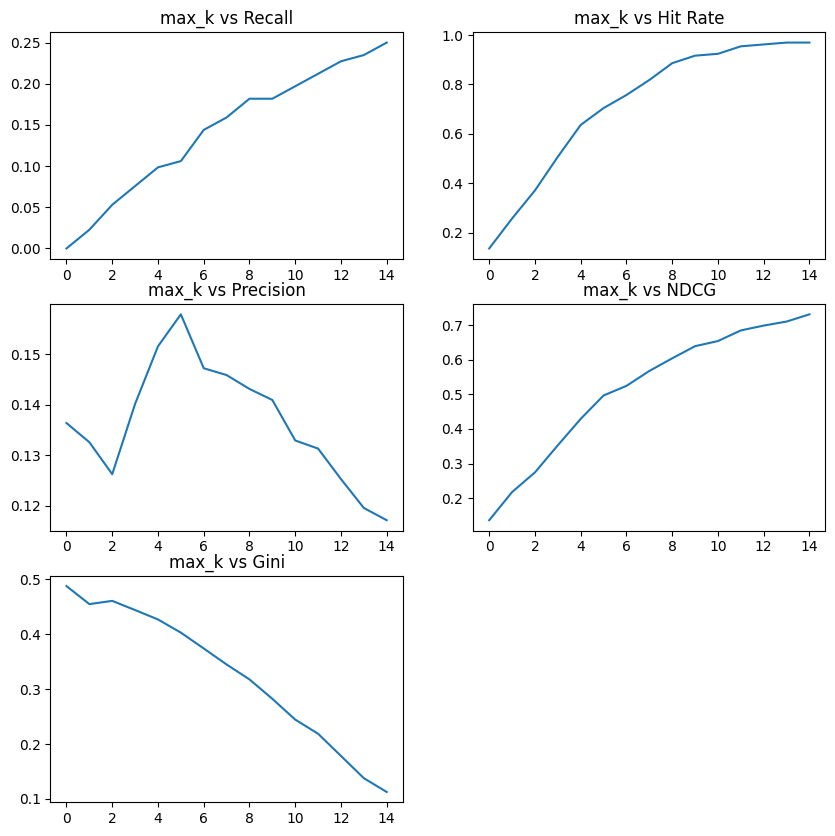

In [28]:
max_k = 15
user_history_length = torch.sum(test_env.current_user_history, 1).detach().cpu().numpy()
test_res_ = torch.stack(test_res).transpose(0,1).detach().cpu().numpy()
report = get_test_results(test_res_, user_history_length, test_gini_coefficient, max_k)

%matplotlib inline
recall = np.mean(report["recall"],0)
hit_rate = np.mean(report["hit_rate"],0)
precision = np.mean(report["precision"],0)
ndcg = np.mean(report["ndcg"],0)
gini_index = report["gini_index"]

plt.figure(figsize = (10,10))
plt.subplot(3,2,1)
plt.plot(np.arange(max_k), recall)
#plt.plot(recall)
plt.title("max_k vs Recall")
plt.subplot(3,2,2)
plt.plot(np.arange(max_k), hit_rate)
plt.title("max_k vs Hit Rate")
plt.subplot(3,2,3)
plt.plot(np.arange(max_k), precision)
plt.title("max_k vs Precision")
plt.subplot(3,2,4)
plt.plot(np.arange(max_k), ndcg)
plt.title("max_k vs NDCG")
plt.subplot(3,2,5)
plt.plot(np.arange(max_k), gini_index)
plt.title("max_k vs Gini")
plt.show()